In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [26]:
#====Physical Parameters====
#Temperature (K)
T = 25+273
R = 8.314 #Gas Constant (J/mol/K)
F = 96485 #Faraday Constant (C/mol)
    
#====Cathode Materials Physical Parameters====
#Molar Volume (m3/mol) [S8, Li2S8, Li2S4, Li2S2, Li2S]
V_i = np.array([1.239e-4, 1.361e-4, 7.415e-5, 4.317e-5, 2.768e-5])
    
#Material Density (kg/m3)
rho_carbon_true = 2000 
rho_carbon_bulk = 120 #Typical of high porosity Ketjen black 120
    
    #Porosity of carbon support
eps_void_carbon = 1 - rho_carbon_bulk/rho_carbon_true
#eps_carbon = 1 - eps_void_carbon
    
    #====Electrolyte Physical Parameters====
    #Species charge [Li^+, S8, S8^2-, S6^2-, S4^2-, S2^2-, S^2-, A^-]
z_i = np.array([1, 0, -2, -2, -2, -2, -2, -1])
    
    #Species Diffusivity (m2/s) [Li^+, S8, S8^2-, S6^2-, S4^2-, S2^2-, S^2-, A^-]
D_i = np.array([1e-10, 1e-9, 6e-10, 6e-10, 1e-10, 1e-10, 1e-10, 4e-10])
    
    #====Initial Cathode Dry Composition====
w_S = 0.7 #Mass Fraction Sulfur 
mg_S_cm2 = 1 #Areal Mass Loading Sulfur (mg/cm2)
m_S = mg_S_cm2/10**6*100**2 #Areal sulfur mass loading (kg/m2)
    #Mass Fraction [S8, C]
w_i = np.array([w_S, 1 - w_S])
    #Molar mass (kg/mol)
M_i = np.array([0.25648, 0.012011])
    #Moles at 1kg basis (mol)
n_i_dry = w_i/M_i
    #Molar volumes (m3/mol) 
V_S_n = 1.239e-4
V_C_n_bulk = M_i[1]/rho_carbon_bulk
V_C_n_true = M_i[1]/rho_carbon_true
    #Volumes at 1 kg basis (m3)
V_S = V_S_n*n_i_dry[0]
V_C_bulk = V_C_n_bulk*n_i_dry[1]
V_C_true = V_C_n_true*n_i_dry[1]
V_void_C = V_C_bulk*eps_void_carbon
V_void_cat = V_void_C - V_S
    #Initial Volume Fraction of Sulfur
eps_S_init = V_S/V_C_bulk #Approximate. Valid until ~95% Sulfur loading.
eps_carbon = V_C_true/V_C_bulk
    
    #====Reaction Parameters====
    #Butler-Volmer Parameters
i_o_i = np.array([0.394, 1.972, 0.019, 0.019, 1.97e-4, 1.97e-4])
alpha = 0.5
n_elec = 1
U_half = np.array([0.0, 2.39, 2.37, 2.24, 2.04, 2.01])

#Stoichiometric coefficients, s_i_j of species i in reaction j
s_i_j = np.array([[-1,0,0,0,0,0,0,0],
                 [0, -1/2,1/2,0,0,0,0,0],
                 [0,0,-3/2,2,0,0,0,0],
                 [0,0,0,-1,3/2,0,0,0],
                 [0,0,0,0,-1/2,1,0,0],
                 [0,0,0,0,0,-1/2,1,0]])

    #Precipitation Parameters [S8, Li2S8, Li2S4, Li2S2, Li2S]
k_precip = np.array([1, 1e-4, 9.98e-5, 9.98e-5, 27.5])
K_sol = np.array([19, 38.09, 11.26, 5.1e-3, 3.0e-5])
C_i_k_ref = np.array([1/V_S_n, 1e-20, 1e-20, 1e-20, 1e-20])
    
    #====Initial Conditions====
    #Reference (Initial) Concentrations (mol/m3) [Li^+, S8, S8^2-, S6^2-, S4^2-, S2^2-, S^2-, A^-]
C_i_l_ref = np.array([1001.0440010474534, 19.0, 0.178, 0.324, 0.020, 5.229e-7, 8.267e-10, 1000.0])

    #Reference Half Cell Potentials
U_half_ref = U_half - R*T/n_elec/F*np.sum(s_i_j*C_i_l_ref/1000)


    #Initial Liquid Porosity
eps_elyte_sep_init = 0.39 #separator
eps_elyte_cat_init = V_void_cat/V_C_bulk #cathode (Assuming negligible sulfur contribution to cathode volume)
    
    #Bruggeman Correlation
b_sep = -0.5
b_cat = -0.5
b_carbon = -0.5
tau_elyte_sep_init = eps_elyte_sep_init**b_sep
tau_elyte_cat_init = eps_elyte_cat_init**b_cat
tau_carbon = eps_carbon**b_carbon
    
    #Initial Volume Fractions [S8, Li2S8, Li2S4, Li2S2, Li2S]
eps_i_cat_init = np.array([eps_S_init, 1e-6, 1e-6, 1e-6, 1e-7])
eps_i_sep_init = np.array([1e-12, 1e-6, 1e-6, 1e-6, 1e-7])
    
    #Initial Cathode Surface Area (m2/m3)
a_init = 1270.*rho_carbon_bulk*(eps_elyte_cat_init/eps_void_carbon)**1.5
xi = 1.5

#Cathode Electronic Conductivity
sigma_C_pure = 1.28e5 #S/m
sigma_C_eff = eps_carbon/tau_carbon*sigma_C_pure

#Cathode Thickness (m)
l_cat = V_S_n/M_i[0]*m_S/eps_S_init

#Separator Thickness (m)
l_sep = 25e-6

#Cell Thickness (m)
l_cell = l_cat + l_sep

#x-discretization
nodes = 20
x = np.linspace(0, l_cell, nodes)
dx = l_cell/nodes

sep_cat_node = int(round(l_sep/dx)) + 1

#Cutoff Voltage (V)
V_cutoff = 1.5

#Applied Current Density
Q_theo = 1675 #Ah/kg_S
C_rate_1 = Q_theo #A/kg_S
C_rate = 0.1 #Applied C-rate
applied_current = 10 #C_rate*C_rate_1*m_S #A/m2

#Lithium stripping overpotential
i_o_Li = 0.394 #A/m2
C_Li = C_i_l_ref[0]
C_Li_ref = C_i_l_ref[0]
nu_Li = -1

def BV_an(eta, i_o_Li, C_Li, C_Li_ref, nu_Li, alpha, F, R, T):
    return i_o_Li*((C_Li/C_Li_ref)**nu_Li*np.exp(alpha*F*eta/R/T) - ((C_Li/C_Li_ref)**(-nu_Li))*np.exp(-alpha*F*eta/R/T)) \
    - applied_current

eta_strip = fsolve(BV_an, 1, args=(i_o_Li, C_Li, C_Li_ref, nu_Li, alpha, F, R, T))

print(sep_cat_node)

9


In [27]:
#Initialize ionic species concentration array
C_i = np.zeros((8, len(x)))

#Populate initial conditions
for i in range(8):
    C_i[i] = C_i_l_ref[i]
    

In [28]:
def BV_cat(phi_cat_ref, i_o_i, C_i, C_i_l_ref, s_i_j, alpha, F, R, T, sep_cat_node, phi_strip):
    eta_j = phi_cat_ref - phi_strip - U_half_ref
    i_j_ref = i_o_i*((np.prod((C_i[:,sep_cat_node+1]/C_i_l_ref)**s_i_j))*np.exp(alpha*F*eta_j/R/T) - \
            (np.prod((C_i[:,sep_cat_node+1]/C_i_l_ref)**-s_i_j))*np.exp(-alpha*F*eta_j/R/T))
    return np.sum(i_j_ref[1:])

In [29]:
#Initialize electrolyte porosity array
eps_elyte = np.zeros(len(x))

#Populate initial conditions
for i in range(nodes):
    if x[i] < l_sep:
        eps_elyte[i] = eps_elyte_sep_init
    else:
        eps_elyte[i] = eps_elyte_cat_init
     

In [30]:
#Initialize solid volume fraction array
eps_k = np.zeros((5, len(x)))

#Populate initial conditions
for i in range(5):
    for j in range(nodes):
        if x[j] < l_sep:
            eps_k[i,j] = eps_i_sep_init[i]
        else:
            eps_k[i,j] = eps_i_cat_init[i]
            

In [31]:
#Initialize current array with initial guesses and boundary conditions
##Row 0 -> solid phase
##Row 1 -> electrolyte phase
current = applied_current*np.ones((2, len(x)))
current[0, :-1] = current[1,-1:] = 0

for i in range (nodes-sep_cat_node):
    current[0,sep_cat_node+i] = i/(nodes-sep_cat_node-1)*applied_current
    current[1,sep_cat_node+i] = applied_current - current[0,sep_cat_node+i]

#Electrolyte/Solid Current Derivative Arrays
di_s_dx = np.zeros(len(x))
di_e_dx = np.zeros(len(x))
#di_e_dx[1,1] = 1
print(current)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.
   9. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.  9.  8.  7.  6.  5.  4.  3.  2.
   1.  0.]]


In [32]:
#Initialize potential array with initial guesses
##Row 0 -> solid phase
##Row 1 -> electrolyte phase
phi = np.zeros((2, len(x)))
phi_strip = 0 - eta_strip - U_half_ref[0]
phi[1,1:] = phi_strip #Lithium stripping overpotential
phi_cat_ref = fsolve(BV_cat, 2.5, args = (i_o_i, C_i, C_i_l_ref, s_i_j, alpha, F, R, T, sep_cat_node, phi_strip))

for i in range (nodes-sep_cat_node-1):
    phi[0,sep_cat_node+i+1] = phi_cat_ref*(1-0.0001*i) #This value comes from the zero-solid-current boundary condition

#Electrolyte/Solid Potential Derivative Arrays
dphi_s_dx = np.zeros(len(x))
dphi_e_dx = np.zeros(len(x))
print(phi)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          2.21451955  2.21429809
   2.21407664  2.21385519  2.21363374  2.21341229  2.21319084  2.21296938
   2.21274793  2.21252648]
 [ 0.         -0.19211113 -0.19211113 -0.19211113 -0.19211113 -0.19211113
  -0.19211113 -0.19211113 -0.19211113 -0.19211113 -0.19211113 -0.19211113
  -0.19211113 -0.19211113 -0.19211113 -0.19211113 -0.19211113 -0.19211113
  -0.19211113 -0.19211113]]


In [33]:
#Initialize surface area array with initial values (m2/m3)
a = np.ones(len(x))

for i in range(nodes):
    if x[i] > l_sep:
        a[i] = a_init

In [34]:
i_j = np.zeros_like(i_o_i)
eta_j = np.zeros([len(i_o_i),len(x)])
#j = nodes-1
#for k in range(5): #Loop through 5 cathodic faradaic reactions
#            eta_j[k+1,j] = phi[0,j] - phi[1,j] - U_half_ref[k+1] #Use [k+] to exclude lithium stripping reaction
#            i_j[k+1] = i_o_i[k+1]*((np.prod((C_i[:,j]/C_i_l_ref)**s_i_j[k+1]))*np.exp(alpha*F*eta_j[k+1,j]/R/T) - \
#            (np.prod((C_i[:,j]/C_i_l_ref)**-s_i_j[k+1]))*np.exp(-alpha*F*eta_j[k+1,j]/R/T))
#            i_sum = i_sum + i_j[k+1] #Add to the current sum counter
            
#print(eta_j)

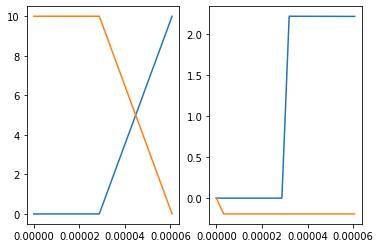

In [35]:
fig, axs = plt.subplots(1,2)
axs[0].plot(x, current[0])
axs[0].plot(x, current[1])
axs[1].plot(x, phi[0])
axs[1].plot(x, phi[1])

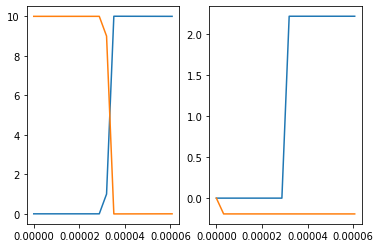

In [36]:
for k in range(500): #Iterate to converge on solution
    #####Current block
    for j in range(nodes-2, sep_cat_node+1, -1): #Loop backward through cathode location x
        #a[j] = a_init #Calculate the cathode surface area
        i_sum = 0 #Set faradaic current sum counter
        for k in range(5): #Loop through 5 cathodic faradaic reactions
            eta_j[k+1,j+1] = phi[0,j+1] - phi[1,j+1] - U_half_ref[k+1] #Use [k+] to exclude lithium stripping reaction
            i_j[k+1] = i_o_i[k+1]*((np.prod((C_i[:,j+1]/C_i_l_ref)**s_i_j[k+1]))*np.exp(alpha*F*eta_j[k+1,j+1]/R/T) - \
            (np.prod((C_i[:,j+1]/C_i_l_ref)**-s_i_j[k+1]))*np.exp(-alpha*F*eta_j[k+1,j+1]/R/T))
            i_sum = i_sum + i_j[k+1] #Add to the current sum counter
        di_e_dx[j+1] = a[j+1]*i_sum #Electrolyte current derivative
        di_s_dx[j+1] = -di_e_dx[j+1] #Solid current derivative
        for i in range(2): #Backward Finite Difference Calculation
            if i == 0:    
                current[i,j] = current[i,j+1] - di_s_dx[j+1]*dx
            else:
                current[i,j] = current[i,j+1] - di_e_dx[j+1]*dx
        #####Potential Block
    for j in range(sep_cat_node+2, nodes): #Loop forward through cathode location x
        dphi_s_dx[j-1] = -current[0,j-1]/sigma_C_eff #Solid potential derivative
            #dphi_s_dx[-1] = -applied_current/sigma_C_eff #Boundary Condition
            
            
            ##########################CONTINUE HERE################
        D_i_eff = eps_elyte[j-1]/tau_elyte_cat_init*D_i
        dC_i_dx = (C_i[:,j] - C_i[:,j-1])/dx
        d = -F*z_i*D_i_eff*eps_elyte[j-1]*dC_i_dx
        d_sum = np.sum(d)
        
        e = F**2*z_i**2*eps_elyte[j-1]*D_i*C_i[:,j-1]/R/T
        e_sum = np.sum(e)
            #######################################################
        dphi_e_dx[j-1] = (current[1,j-1] - d_sum)/-e_sum ##Electrolyte potential derivativeReplace ones with sumA and sumB
            #dphi_e_dx[-1] = 0 #Boundary Condition
        for i in range(2): #Forward Finite Difference Calculation
            if i == 0: 
                phi[i,j] = phi[i,j-1] + dphi_s_dx[j-1]*dx
            else:
                phi[i,j] = phi[i,j-1] + dphi_e_dx[j-1]*dx
fig, axs = plt.subplots(1,2)
axs[0].plot(x, current[0])
axs[0].plot(x, current[1])
axs[1].plot(x, phi[0])
axs[1].plot(x, phi[1])

#print(d_sum)
#plt.plot(x[sep_cat_node+2:],current[0,sep_cat_node+2:])
#plt.plot(x[sep_cat_node+2:],current[1,sep_cat_node+2:])
#plt.show
#plt.plot(x,di_e_dx)
#plt.plot(x,di_s_dx)
#plt.plot(x,dphi_e_dx)
#plt.plot(x,dphi_s_dx)
#plt.plot(x[sep_cat_node+1:],phi[0,sep_cat_node+1:])
#plt.plot(x[1:],phi[1,1:])
#print(current)
